In [72]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import scale

In [61]:
#####
# PART - I : Create target value column & transform data
#####

X_train = pd.read_csv('yelp_train.csv')
X_test = pd.read_csv('yelp_test.csv')
predictors = list(X_train.columns)
predictors.remove('stars')
# target = 'positive'
y_train = np.array([int(v >= 4) for v in X_train['stars']])
y_test = np.array([int(v >= 4) for v in X_test['stars']])

# Transform column 'date' to timestamp format in integer type, so that temporal dynamic info can be better used
# divide (prescale) the timestamp to avoid numeric issue when scaling the whole dataset
dstr_to_timestamp = lambda s: int(datetime.strptime(s, "%Y-%m-%d").timestamp()) / 1000.0 
X_train['date'] = X_train['date'].apply(dstr_to_timestamp)
X_test['date'] = X_test['date'].apply(dstr_to_timestamp)

# Scale the data for better performance
X_train = DataFrame(scale(X_train.loc[:, predictors]), columns = predictors)
X_test = DataFrame(scale(X_test.loc[:, predictors]), columns = predictors)

n_col = len(predictors)  # after stripping 'stars' it's now 14

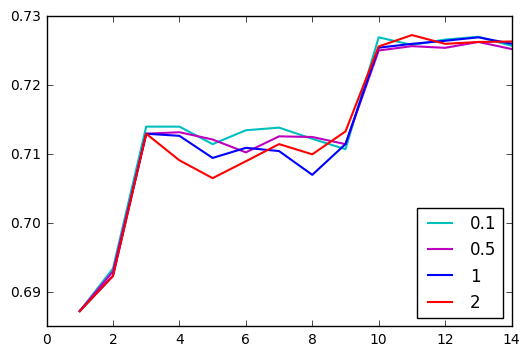


Optimal n_feature = 11, optimal MSE = 0.727295

Predictors:
 ['biz_stars', 'user_average_stars', 'words', 'characters', 'biz_review_count', 'funny', 'biz_open', 'useful', 'user_review_count', 'cool', 'user_useful']


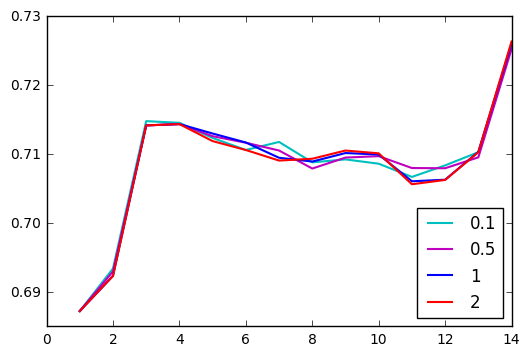


Optimal n_feature = 14, optimal MSE = 0.726363

Predictors:
 ['biz_stars', 'user_average_stars', 'characters', 'user_cool', 'user_useful', 'date', 'words', 'user_review_count', 'useful', 'biz_review_count', 'funny', 'user_funny', 'biz_open', 'cool']


In [93]:
#####
# PART - II : Model Training & Model Selection
#####

# PART - 2.1 : Linear Regression
# ==============================

# lr = LogisticRegression()
# lr.fit(X_train, y_train)
# f1_lr = f1_score(y_test, lr.predict(X_test))
# print('(1) F1-Score of LR:', f1_lr)
# pred_rank_lr = [(pname, _) for pname, _ in sorted(zip(predictors, lr.coef_[0]), 
#                 key=lambda x: abs(x[1]), reverse=True)]
# print('\n(2) Predictors Ranking (descending):\n\t', pred_rank_lr, '\n')


#print('\n', ranked_features)

# For each possible C value in logistic regression model, 
# do feature selection separately and plot the corresponding f1-scores.
def pre_tuning_plot(f_scores, clf, parameter):
    ranked_features = [pname for pname, _ in sorted(zip(predictors, f_scores), 
                        key=lambda x: x[1], reverse=True)]
    opt_n_feature, opt_f1 = 0, 0.0
    plt.subplot(111)
    for param, color in ((0.1, 'c'), (0.5, 'm'), (1, 'b'), (2, 'r')):
        clf.__dict__[parameter] = param
        scores = []
        for n_f in range(1, n_col+1):
            columns = ranked_features[:n_f]
            sc = cross_val_score(clf, X_train.loc[:, columns], y_train, scoring='f1', cv=5).mean()
            # estimator.fit(X_train.loc[:, columns], y_train)
            # sc = f1_score(y_test, estimator.predict(X_test.loc[:, columns]))
            scores.append(sc)
            if sc > opt_f1:
                opt_n_feature, opt_f1 = n_f, sc
        plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=param)
    plt.legend(loc='lower right')
    plt.show()

    print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_f1))
    print('\nPredictors:\n', ranked_features[:opt_n_feature])

Fval, pval = f_classif(X_train, y_train)
pre_tuning_plot(Fval, LogisticRegression(), 'C')
mic = mutual_info_classif(X_train, y_train)
pre_tuning_plot(mic, LogisticRegression(), 'C')


In [94]:
columns = ['biz_stars', 'user_average_stars', 'characters', 'biz_review_count']
lr = LogisticRegression(C=1.0)
sc = cross_val_score(lr, X_train.loc[:, columns], y_train, scoring='f1', cv=5).mean()
print(sc)

0.713134455872


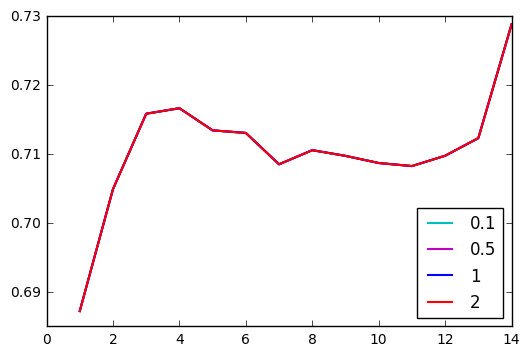


Optimal n_feature = 14, optimal MSE = 0.728842

Predictors:
 ['biz_stars', 'user_average_stars', 'characters', 'user_cool', 'user_useful', 'date', 'words', 'user_review_count', 'useful', 'biz_review_count', 'funny', 'user_funny', 'biz_open', 'cool']


In [ ]:
# PART - 2.2 : Support Vector Machine Classifier (SVC)
# ===========================
# PART - 2.2.1: Default Model 

pre_tuning_plot(mic, SVC(kernel='linear', C=1.0), 'gamma')
pre_tuning_plot(mic, SVC(kernel='poly', C=1.0), 'gamma')
pre_tuning_plot(mic, SVC(kernel='rbf', C=1.0), 'gamma')

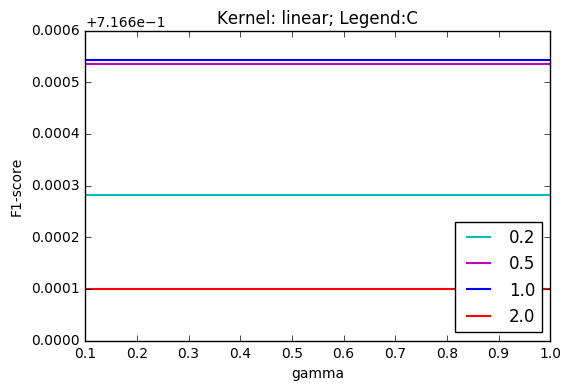

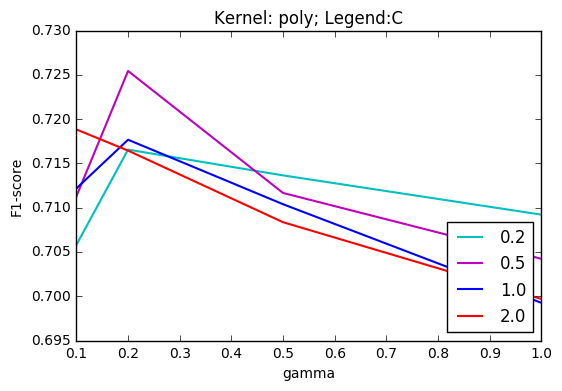

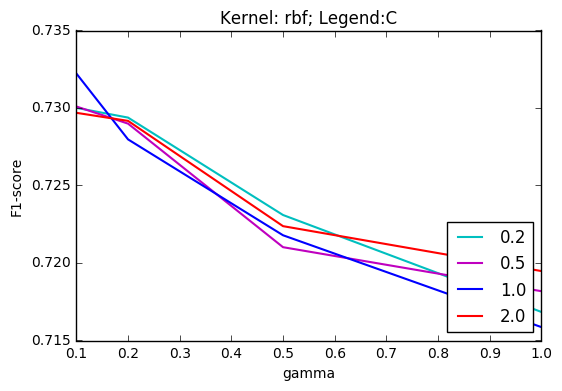

In [102]:
def param_tuning(cols, clf, param_legend, range_legend, param_x, range_x):
    color_list = ['c', 'm', 'b', 'r']
    # opt_f1 = 0.0
    plt.subplot(111)
    plt.title('Kernel: ' + clf.__dict__['kernel'] + '; Legend:' + param_legend)
    plt.xlabel(param_x)
    plt.ylabel('F1-score')
    for p1, color in zip(range_legend, color_list):
        clf.__dict__[param_legend] = p1
        scores = []
        for p2 in range_x:
            clf.__dict__[param_x] = p2
            sc = cross_val_score(clf, X_train.loc[:, cols], y_train, scoring='f1', cv=5).mean()
            scores.append(sc)
#             if sc > opt_f1:
#                 opt_n_feature, opt_f1 = n_f, sc
        plt.plot(range_x, scores, color, linewidth=1.5, label=str(p1))
    plt.legend(loc='lower right')
    plt.show()

#     print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_f1))
#     print('\nPredictors:\n', ranked_features[:opt_n_feature])

selected_col = ['biz_stars', 'user_average_stars', 'characters', 'biz_review_count']
range_legend, range_x = [0.2, 0.5, 1.0, 2.0], [0.1, 0.2, 0.5, 1.0]
param_tuning(selected_col, SVC(kernel='linear'), 'C', range_legend, 'gamma', range_x)
param_tuning(selected_col, SVC(kernel='poly'), 'C', range_legend, 'gamma', range_x)
param_tuning(selected_col, SVC(kernel='rbf'), 'C', range_legend, 'gamma', range_x)